In [2]:
# import sys
# !{sys.executable} -m pip install --user plotly.express
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind, f_oneway
import numpy as np

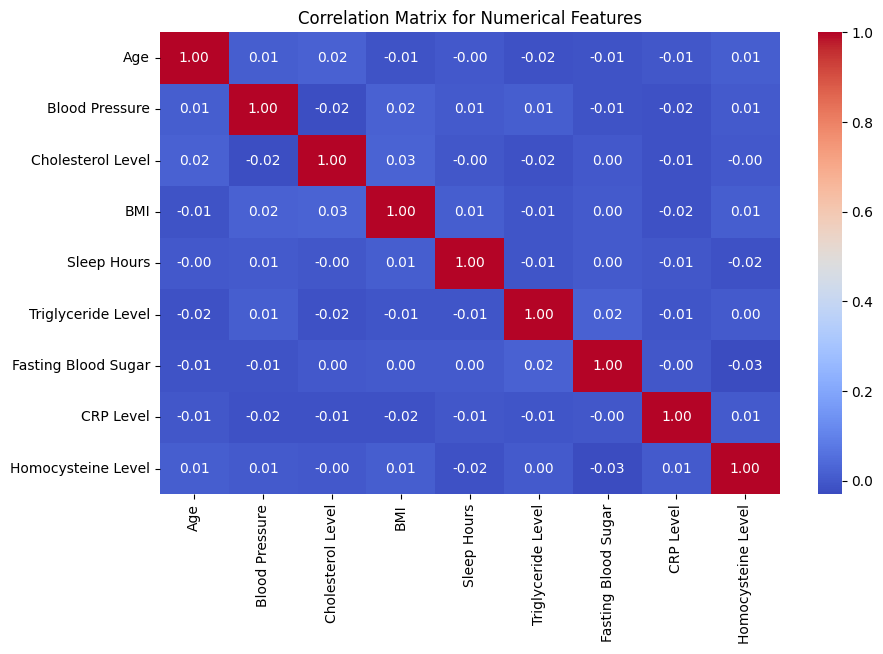

In [119]:
# Load the CSV data
df = pd.read_csv('../data/equal_distribution_hds.csv')
# df = pd.read_csv('cleaned_heart_disease_majority.csv')
# df = pd.read_csv('heart_disease_remove_empty.csv')
numerical_vars = [
    "Age", "Blood Pressure", "Cholesterol Level", "BMI", "Sleep Hours", 
    "Triglyceride Level", "Fasting Blood Sugar", "CRP Level", "Homocysteine Level"
]

categorical_vars = [
    'Gender', 'Exercise Habits', 'Smoking', 'Family Heart Disease', 'Diabetes', 'High Blood Pressure', 
    'Low HDL Cholesterol', 'High LDL Cholesterol', 'Alcohol Consumption', 'Stress Level', 'Sugar Consumption', 'Heart Disease Status'
]

correlation_matrix = df[numerical_vars].corr(method='pearson')

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix for Numerical Features")
plt.show()

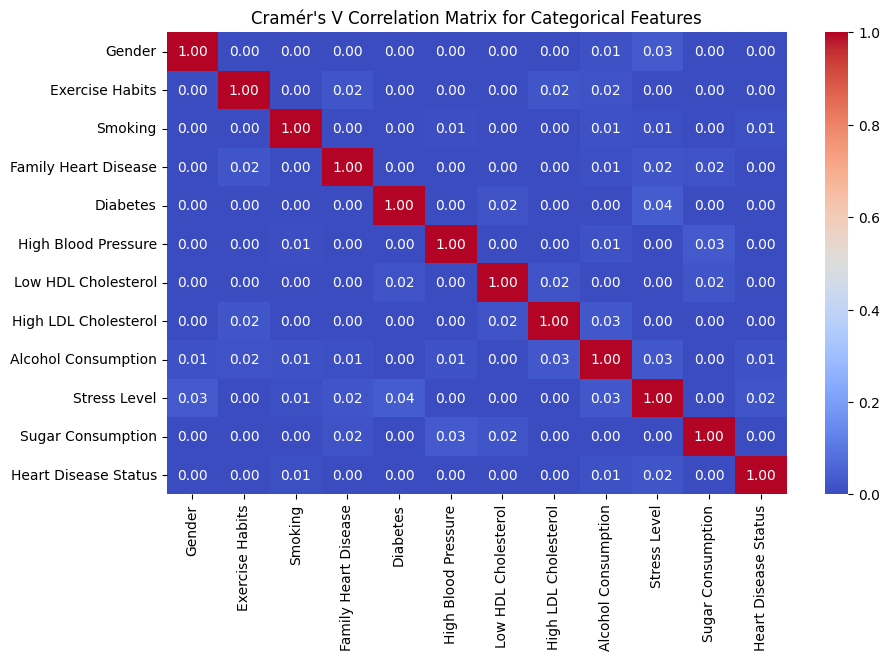

In [111]:
import numpy as np
import scipy.stats as stats

def cramers_v(x, y):
    """
    Calculate Cramér's V statistic for categorical-categorical correlation.
    """
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    r_corr = r - ((r-1)**2) / (n-1)
    k_corr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min(r_corr-1, k_corr-1))

cat_corr_matrix = pd.DataFrame(index=categorical_vars, columns=categorical_vars)

for col1 in categorical_vars:
    for col2 in categorical_vars:
        cat_corr_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

cat_corr_matrix = cat_corr_matrix.astype(float)

plt.figure(figsize=(10, 6))
sns.heatmap(cat_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Cramér's V Correlation Matrix for Categorical Features")
plt.show()


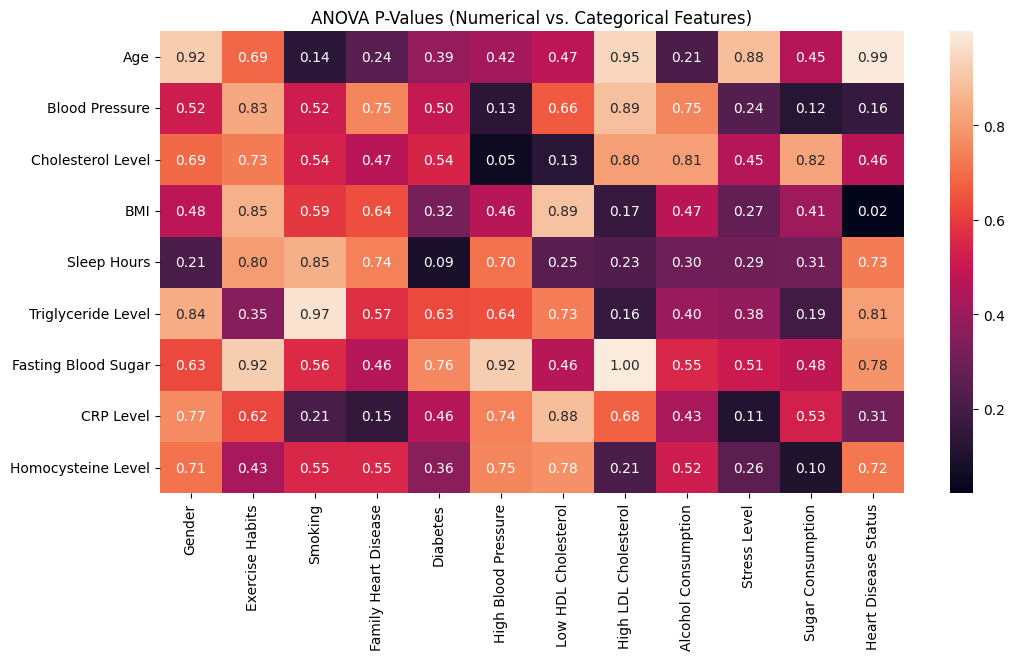

In [120]:
from scipy.stats import f_oneway, pointbiserialr

anova_results = pd.DataFrame(index=numerical_vars, columns=categorical_vars)

for cat in categorical_vars:
    for num in numerical_vars:
        groups = [df[num][df[cat] == category] for category in df[cat].unique()]
        anova_results.loc[num, cat] = f_oneway(*groups)[1]  # p-value

anova_results = anova_results.astype(float)

plt.figure(figsize=(12, 6))
sns.heatmap(anova_results, annot=True, cmap='rocket', fmt=".2f")
plt.title("ANOVA P-Values (Numerical vs. Categorical Features)")
plt.show()


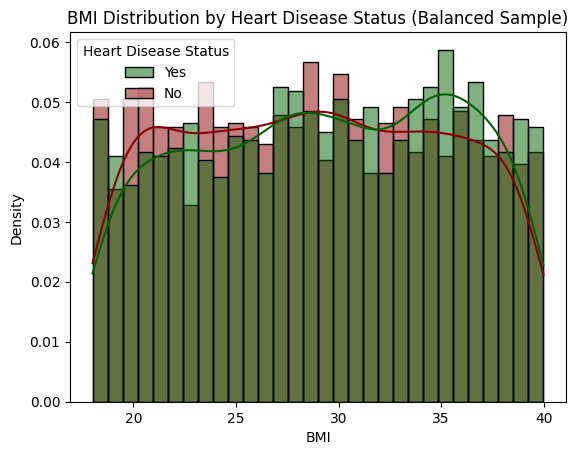

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df, x="BMI", hue="Heart Disease Status", kde=True, bins=30, stat="density", common_norm=False, hue_order=["Yes", "No"], palette={"Yes": "darkgreen", "No": "darkred"})
plt.title("BMI Distribution by Heart Disease Status (Balanced Sample)")
plt.show()


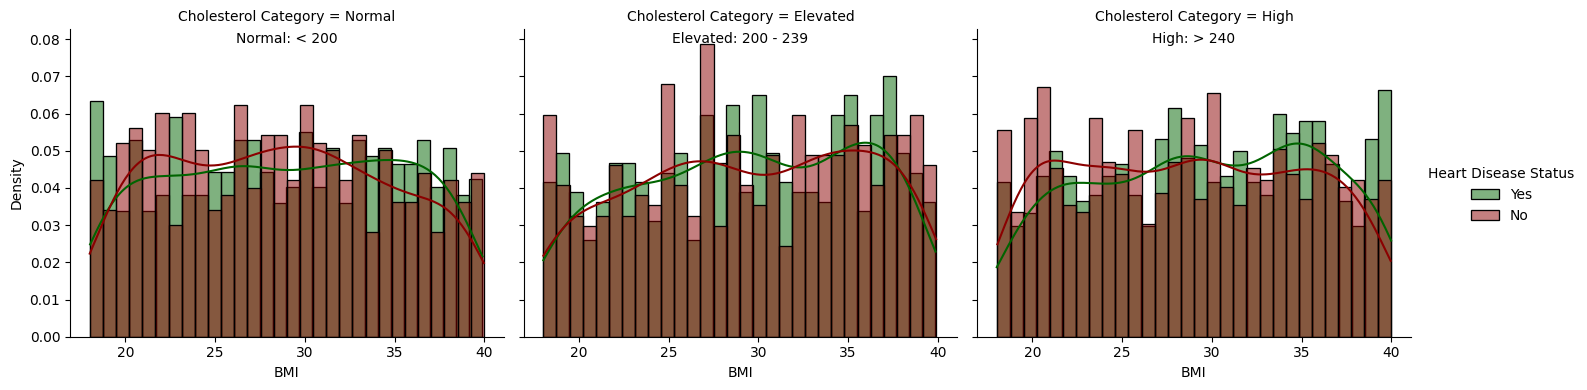

In [122]:
g = sns.FacetGrid(df, col="Cholesterol Category", hue="Heart Disease Status", height=4, aspect=1.2, sharex=True, sharey=True, palette={"No": "darkred", "Yes": "darkgreen"}, hue_order=["Yes", "No"], col_order=["Normal", "Elevated", "High"])
g.map(sns.histplot, "BMI", kde=True, bins=30, stat="density", common_norm=False)
g.add_legend()
for ax in g.axes.flat:
    if ax.get_title() == "Cholesterol Category = Normal":
        ax.text(0.5, 0.97, "Normal: < 200", ha="center", va="center", transform=ax.transAxes, fontsize=10, color="black")
    elif ax.get_title() == "Cholesterol Category = Elevated":
        ax.text(0.5, 0.97, "Elevated: 200 - 239", ha="center", va="center", transform=ax.transAxes, fontsize=10, color="black")
    elif ax.get_title() == "Cholesterol Category = High":
        ax.text(0.5, 0.97, "High: > 240", ha="center", va="center", transform=ax.transAxes, fontsize=10, color="black")

plt.show()


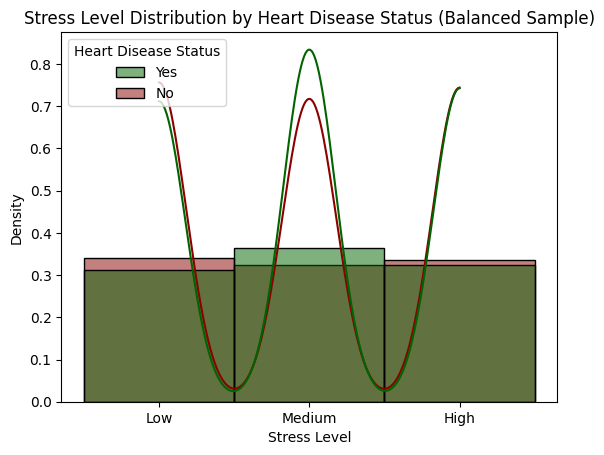

In [ ]:
df['Stress Level'] = pd.Categorical(df['Stress Level'], categories=["Low", "Medium", "High"], ordered=True)
sns.histplot(df, x="Stress Level", hue="Heart Disease Status", kde=True, bins=30, stat="density", common_norm=False, hue_order=["Yes", "No"], palette={"Yes": "darkgreen", "No": "darkred"})
plt.title("Stress Level Distribution by Heart Disease Status (Balanced Sample)")
plt.show()

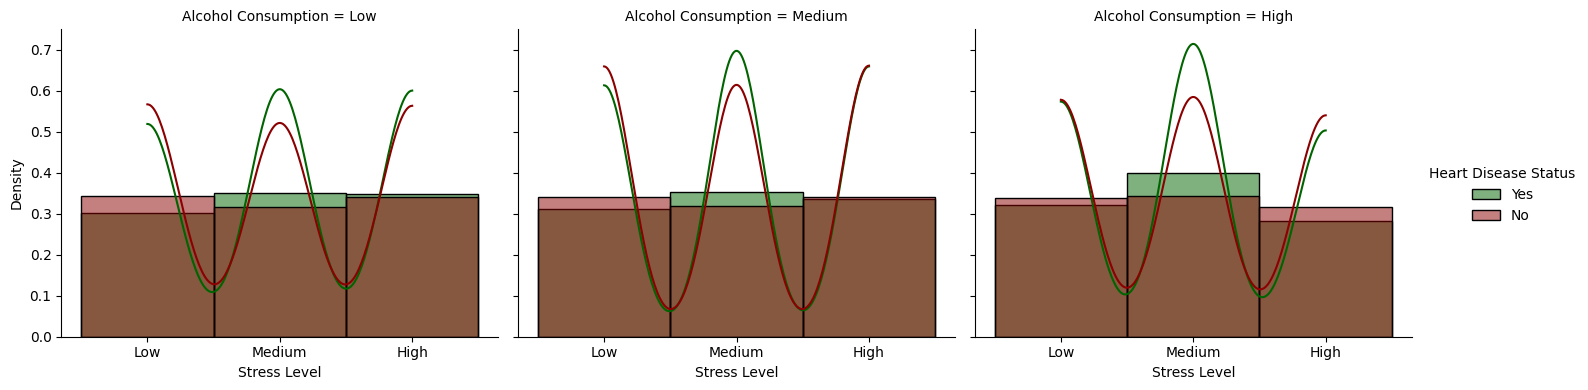

In [124]:
g = sns.FacetGrid(df, col="Alcohol Consumption", hue="Heart Disease Status", height=4, aspect=1.2, sharex=True, sharey=True, hue_order=["Yes", "No"], palette={"Yes": "darkgreen", "No": "darkred"}, col_order=["Low", "Medium", "High"])
g.map(sns.histplot, "Stress Level", kde=True, bins=30, stat="density", common_norm=False)
g.add_legend()
plt.show()

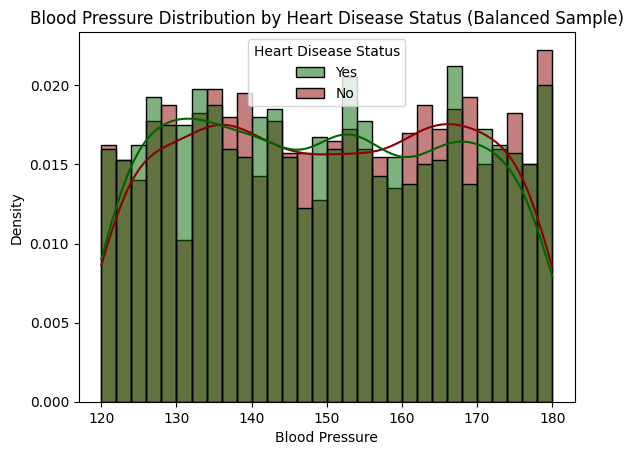

In [130]:
df['Blood Pressure Category'] = pd.Categorical(df['Blood Pressure Category'], categories=["Normal", "Elevated", "High", "Very High"], ordered=True)
sns.histplot(df, x="Blood Pressure", hue="Heart Disease Status", kde=True, bins=30, stat="density", common_norm=False, hue_order=["Yes", "No"], palette={"Yes": "darkgreen", "No": "darkred"})
plt.title("Blood Pressure Distribution by Heart Disease Status (Balanced Sample)")
plt.show()

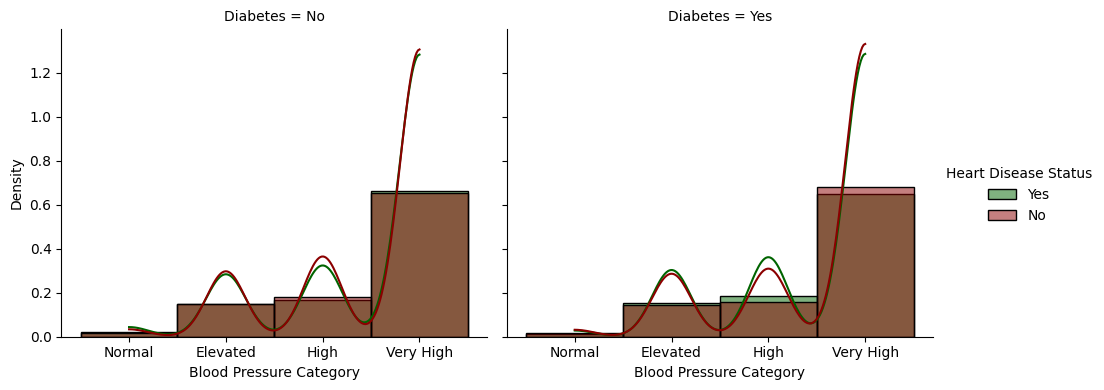

In [133]:
g = sns.FacetGrid(df, col="Diabetes", hue="Heart Disease Status", height=4, aspect=1.2, sharex=True, sharey=True, hue_order=["Yes", "No"], palette={"Yes": "darkgreen", "No": "darkred"})
g.map(sns.histplot, "Blood Pressure Category", kde=True, bins=30, stat="density", common_norm=False)
g.add_legend()
plt.show()

(2000, 25)
Stress Level
Medium    729
High      649
Low       622
Name: count, dtype: int64
(2000, 25)
High Blood Pressure
Yes    1014
No      986
Name: count, dtype: int64
(2000, 25)
Low HDL Cholesterol
No     1007
Yes     993
Name: count, dtype: int64
(2000, 25)
High LDL Cholesterol
Yes    1004
No      996
Name: count, dtype: int64


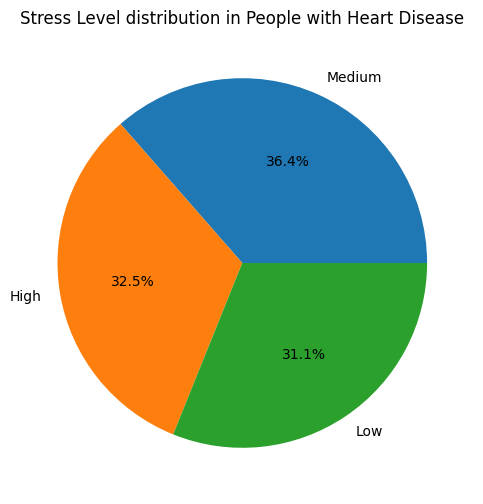

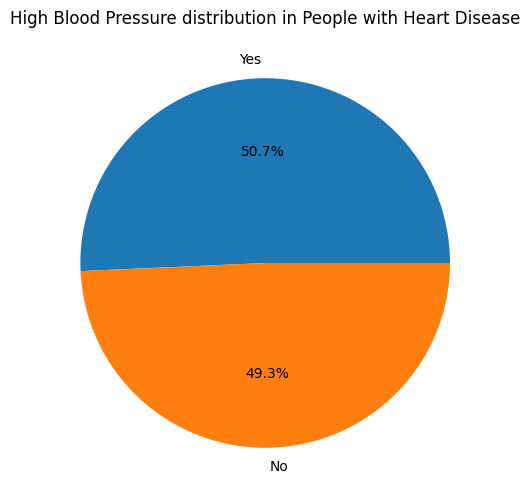

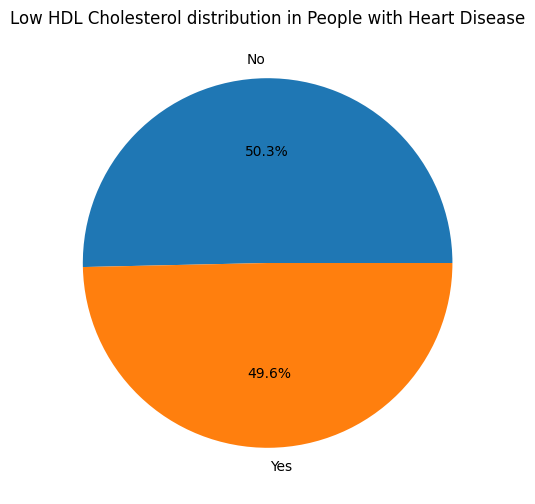

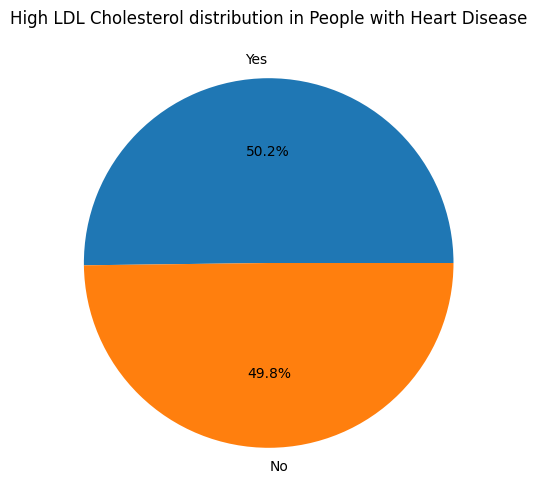

In [118]:
def produce_pie_charts(dataframe: pd.DataFrame, independent_feature: str, dependent_feature: str):
    """
    Produces pie chart of percentage of people with
    the feature indicators that have heart disease.

    :param dataframe: The dataframe to produce the data from.
    :param dependent_feature: The column that depends on the other to create pie chart.
    :param independent_feature: The column that influences the other to create the pie chart.

    :return: Produce a pie chart between the independent and dependent features.
    """
    assert(isinstance(dataframe, pd.DataFrame) and dataframe.shape[0] > 0), "First argument must be a valid DataFrame with at least 1 row"
    assert(isinstance(independent_feature, str) and independent_feature in dataframe.columns), "The second argument must be a valid string feature in the dataframe"
    assert(isinstance(dependent_feature, str) and dependent_feature in dataframe.columns), "The third argument must be a valid string feature in the dataframe"
    df_heart_disease = df[df[dependent_feature].str.lower() == 'yes']
    print(df_heart_disease.shape)
    ind_counts = df_heart_disease[independent_feature].value_counts()
    print(ind_counts)

    plt.figure(figsize=(6,6))
    plt.pie(ind_counts, labels=ind_counts.index, autopct='%1.1f%%')
    plt.title(f"{independent_feature} distribution in People with Heart Disease")
produce_pie_charts(df, "Stress Level", "Heart Disease Status")
produce_pie_charts(df, "High Blood Pressure", "Heart Disease Status")
produce_pie_charts(df, 'Low HDL Cholesterol', 'Heart Disease Status')
produce_pie_charts(df, "High LDL Cholesterol", "Heart Disease Status")



In [ ]:
# Cholesterol Levels
# Below 200 is "normal"
# Above 200 is "high"

# BMI levels
# Below 25 is "normal"
# Above 25 is "bad"

In [22]:
def Age_with_X(X):
    '''
    explore factor X with Heart disease rate among different age
    '''
    # Mapping Heart Disease Status from categorical ('Yes'/'No') to binary (1/0)
    if df['Heart Disease Status'].dtype == 'O': 
        mapping = {'Yes': 1, 'No': 0}
        df['Heart Disease Status'] = df['Heart Disease Status'].map(mapping)

    # Create age groups 
    bins = [0, 30, 40, 50, 60, 70, 80, 100]
    labels = ['<30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+']
    df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

    # Group by AgeGroup and X to calculate the average (proportion) of heart disease.
    # Since Heart Disease Status is 0/1, the mean gives the proportion of cases.
    result = df.groupby(['AgeGroup', X])['Heart Disease Status'].mean().reset_index()
    # print("Heart Disease Proportion by Age Group and %s Status:" % X)
    # print(result)

    # Visualize the proportions with a bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=result, x='AgeGroup', y='Heart Disease Status', hue= X)
    plt.ylabel('Proportion with Heart Disease')
    plt.title('Heart Disease Proportion by %s Status and Age Group' % X)

    # Save the figure
    filename = f'heart_disease_proportion_by_{X}.png'  # Saves dynamically based on X
    plt.savefig(filename, dpi=300, bbox_inches='tight')  # Save at high quality

    # plt.show()


0       24.991591
1       25.221799
2       29.855447
3       24.130477
4       20.486289
          ...    
9995    18.788791
9996    31.856801
9997    26.899911
9998    34.964026
9999    25.111295
Name: BMI, Length: 10000, dtype: float64


C:\Users\Francisco\AppData\Local\Temp\ipykernel_17608\75344317.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df.groupby(['AgeGroup', X])['Heart Disease Status'].mean().reset_index()
C:\Users\Francisco\AppData\Local\Temp\ipykernel_17608\75344317.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df.groupby(['AgeGroup', X])['Heart Disease Status'].mean().reset_index()
C:\Users\Francisco\AppData\Local\Temp\ipykernel_17608\75344317.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cu

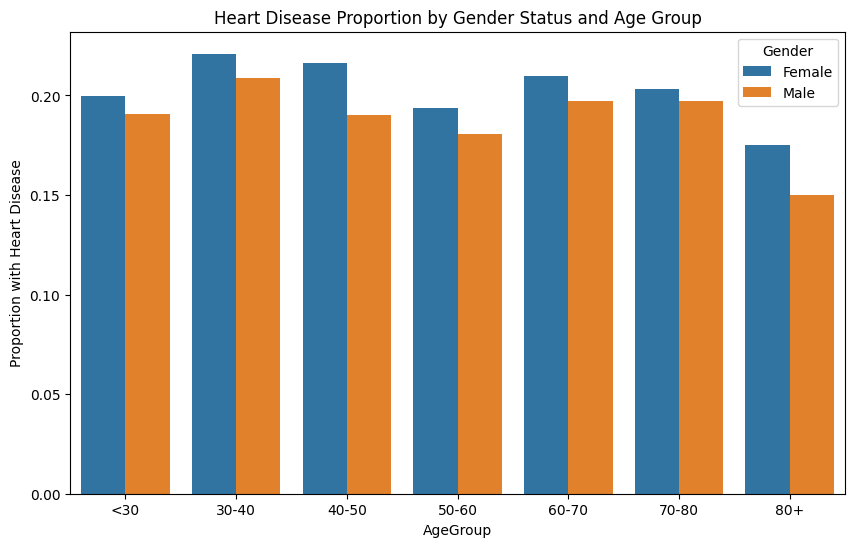

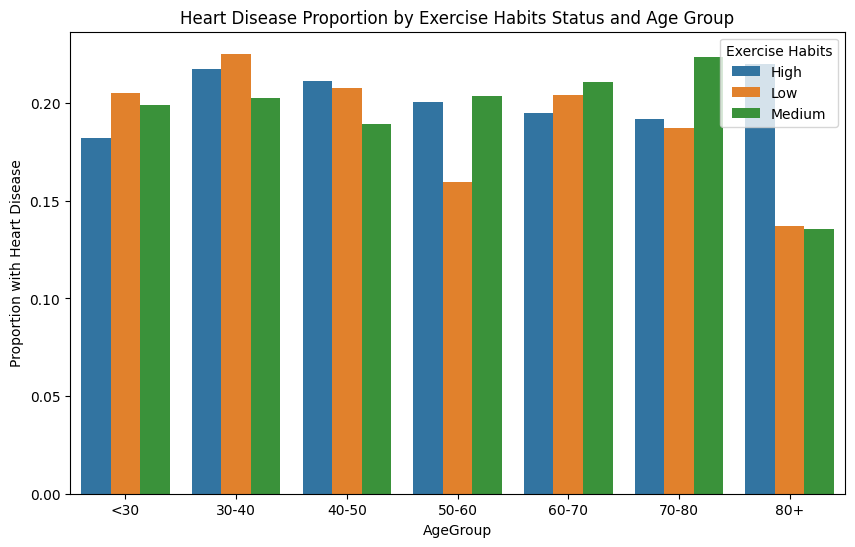

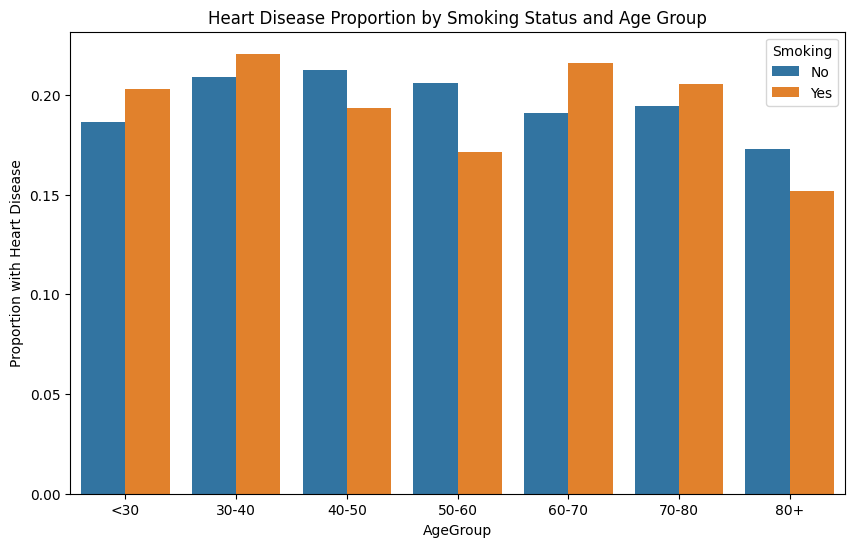

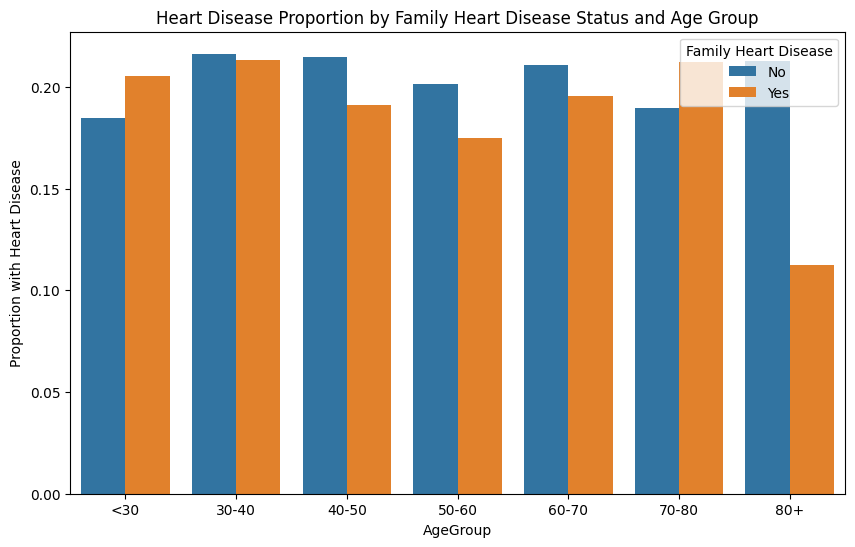

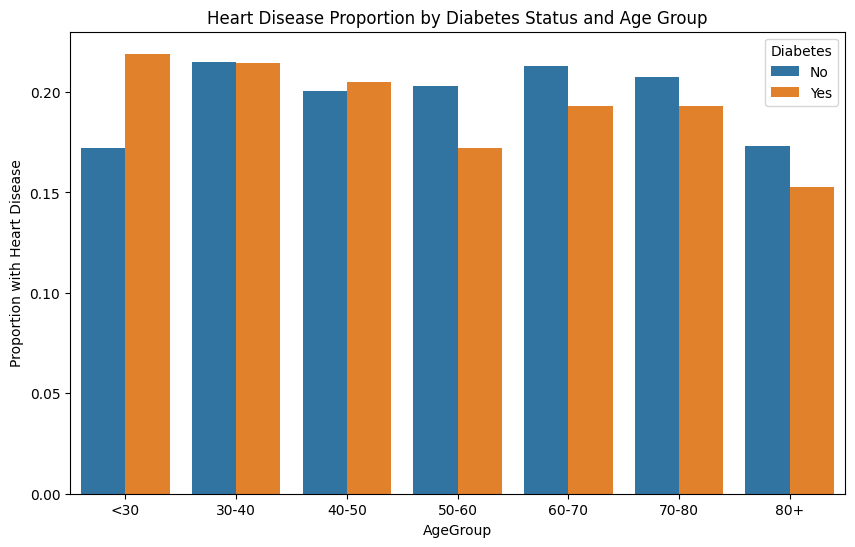

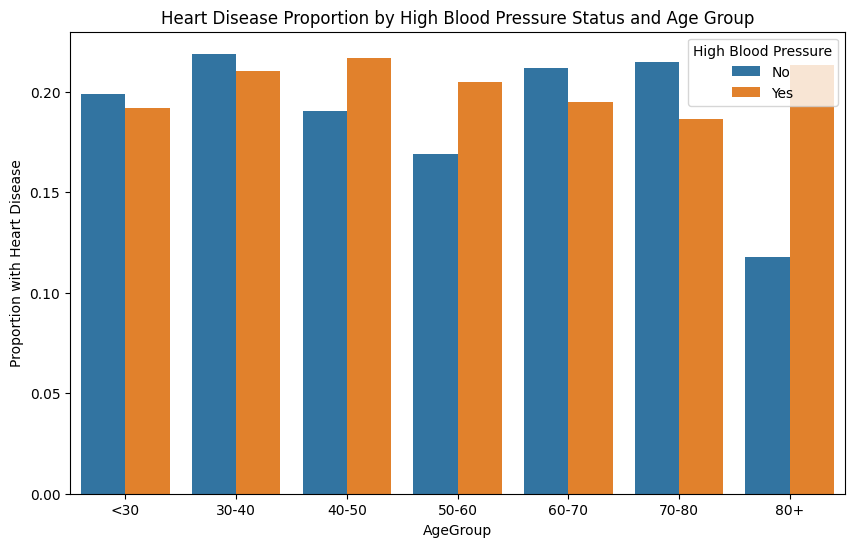

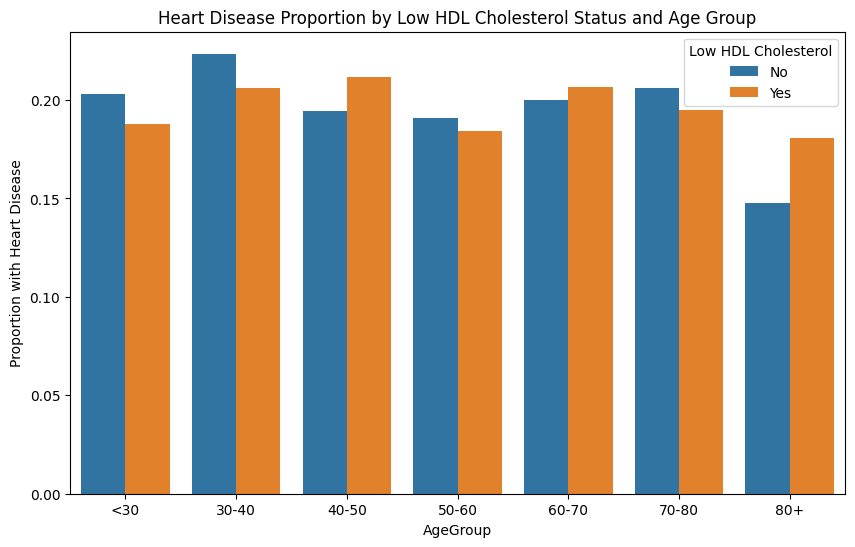

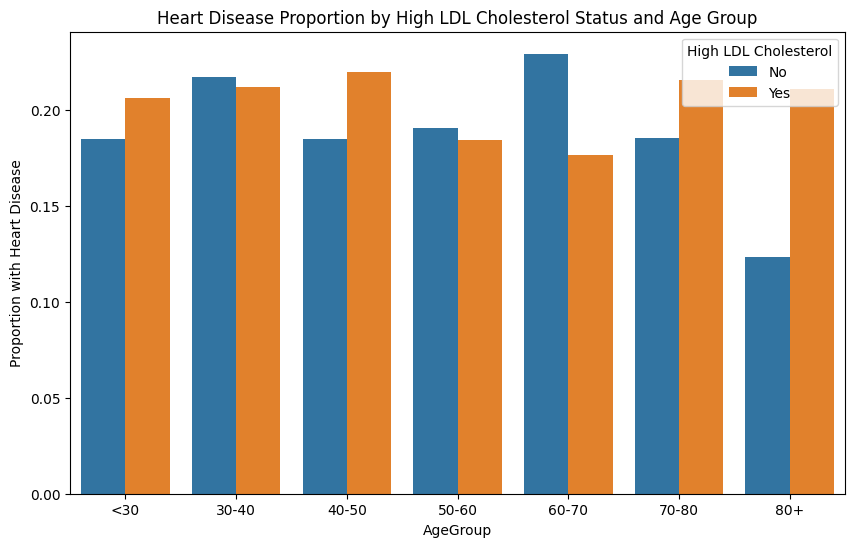

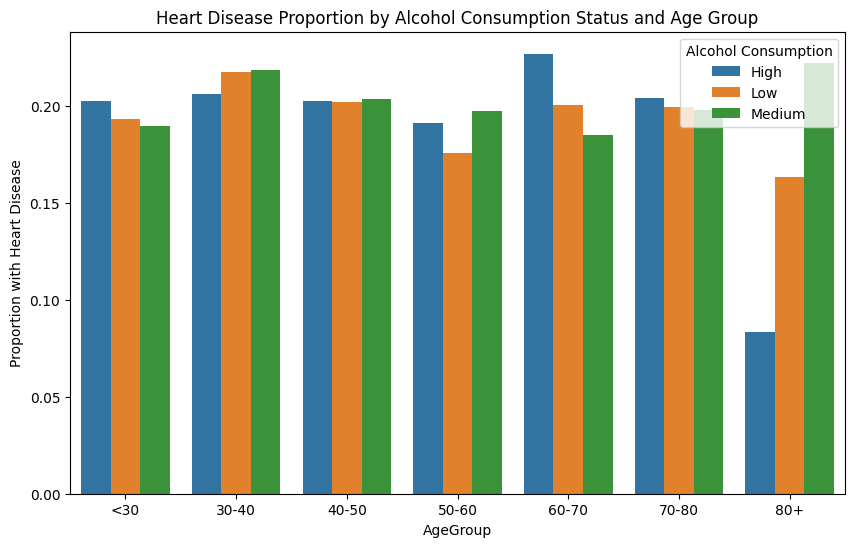

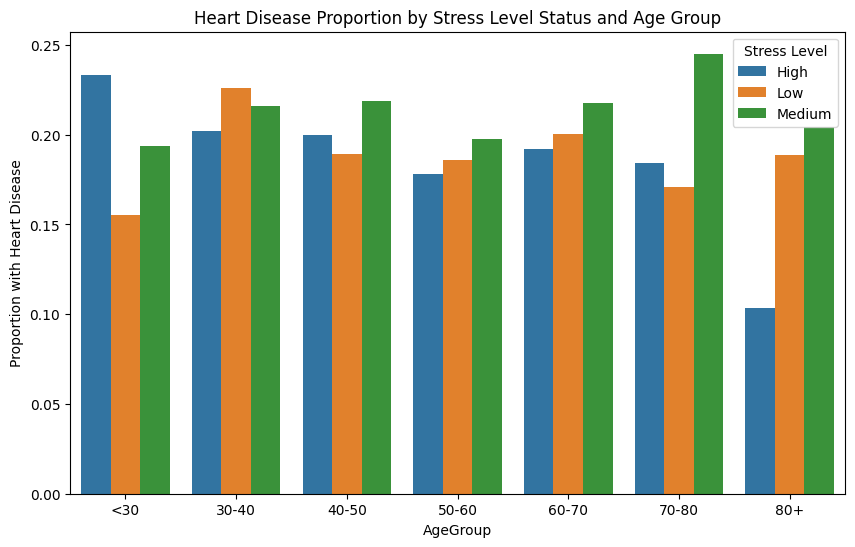

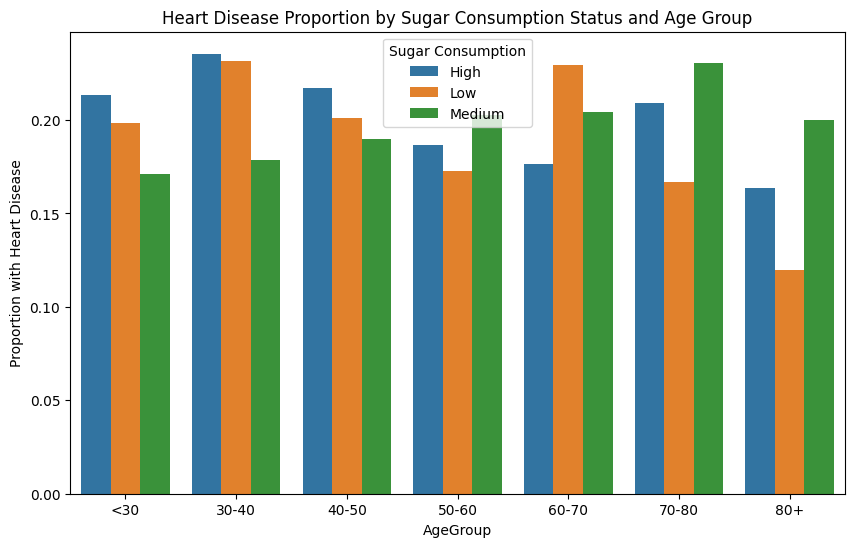

In [ ]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(df["BMI"])

for cate in categorical_columns[:len(categorical_columns)-1]:
    Age_with_X(cate)


In [7]:
# perform a chi-squared test for each age group to test the association
def chi2_test_age_group(group,X):
    # Create a contingency table for X vs. Heart Disease Status
    contingency_table = pd.crosstab(group[X], group['Heart Disease Status'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return pd.Series({'Chi2': chi2, 'p-value': p, 'Degrees of Freedom': dof})


In [8]:
'''
chi2 for age
'''

chi2_results = df.groupby('AgeGroup').apply(lambda g:chi2_test_age_group(g,'Smoking')).reset_index()
print("\nChi-squared Test Results by Age Group:")
print(chi2_results)



Chi-squared Test Results by Age Group:
  AgeGroup      Chi2   p-value  Degrees of Freedom
0      <30  0.696611  0.403925                 1.0
1    30-40  0.269972  0.603351                 1.0
2    40-50  0.770244  0.380141                 1.0
3    50-60  2.802987  0.094089                 1.0
4    60-70  1.359092  0.243695                 1.0
5    70-80  0.239257  0.624743                 1.0
6      80+  0.020927  0.884977                 1.0


C:\Users\Francisco\AppData\Local\Temp\ipykernel_17608\2523869849.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chi2_results = df.groupby('AgeGroup').apply(lambda g:chi2_test_age_group(g,'Smoking')).reset_index()
C:\Users\Francisco\AppData\Local\Temp\ipykernel_17608\2523869849.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  chi2_results = df.groupby('AgeGroup').apply(lambda g:chi2_test_age_group(g,'Smoking')).reset_index()



ANOVA: Age vs. Exercise Habits
F-statistic: 0.62, p-value: 0.5396
=> No significant difference in Exercise Habits among Age.


C:\Users\Francisco\AppData\Local\Temp\ipykernel_17608\3269181182.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  exercise_counts = df.groupby(["AgeGroup", "Exercise Habits"]).size().reset_index(name="Count")
C:\Users\Francisco\AppData\Local\Temp\ipykernel_17608\3269181182.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df.groupby("AgeGroup")["Exercise Habits"].count().reset_index(name="Total")


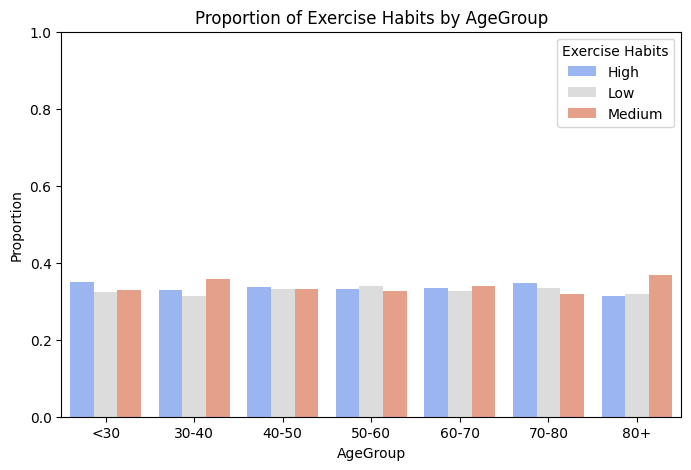

In [9]:
'''exercise habit and age'''

anova_p = f_oneway(
    df[df["Exercise Habits"] == "Low"]["Age"],
    df[df["Exercise Habits"] == "Medium"]["Age"],
    df[df["Exercise Habits"] == "High"]["Age"]
)

print("\nANOVA: Age vs. Exercise Habits")
print(f"F-statistic: {anova_p.statistic:.2f}, p-value: {anova_p.pvalue:.4f}")
if anova_p.pvalue < 0.05:
    print("=> Significant difference in Exercise Habits among different Age.")
else:
    print("=> No significant difference in Exercise Habits among Age.")

# Define the age bins and labels for grouping
bins = [0, 30, 40, 50, 60, 70, 80, 100]
labels = ['<30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+']

# Create age groups
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

exercise_counts = df.groupby(["AgeGroup", "Exercise Habits"]).size().reset_index(name="Count")
total_counts = df.groupby("AgeGroup")["Exercise Habits"].count().reset_index(name="Total")

# Merge and compute proportions
exercise_counts = exercise_counts.merge(total_counts, on="AgeGroup")
exercise_counts["Proportion"] = exercise_counts["Count"] / exercise_counts["Total"]

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=exercise_counts, x="AgeGroup", y="Proportion", hue="Exercise Habits", palette="coolwarm")
plt.title("Proportion of Exercise Habits by AgeGroup")
plt.ylabel("Proportion")
plt.xlabel("AgeGroup")
plt.legend(title="Exercise Habits")
plt.ylim(0, 1)  # Ensures values range between 0 and 1
plt.show()


Chi-Squared Test: Stress Level vs. Heart Disease Status
Chi2: 7.68, p-value: 0.0215
=> There is a significant relationship between Stress Level and Heart Disease.

T-Test: Sleep Hours vs. Heart Disease Status
T-statistic: 0.39, p-value: 0.7002
=> No significant difference in Sleep Hours between groups.

ANOVA: Sleep Hours vs. Stress Level
F-statistic: 2.10, p-value: 0.1225
=> No significant difference in Sleep Hours among Stress Levels.


C:\Users\Francisco\AppData\Local\Temp\ipykernel_17608\2256608339.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=stress_hd, x="Stress Level", y="Heart Disease Status", palette="coolwarm")


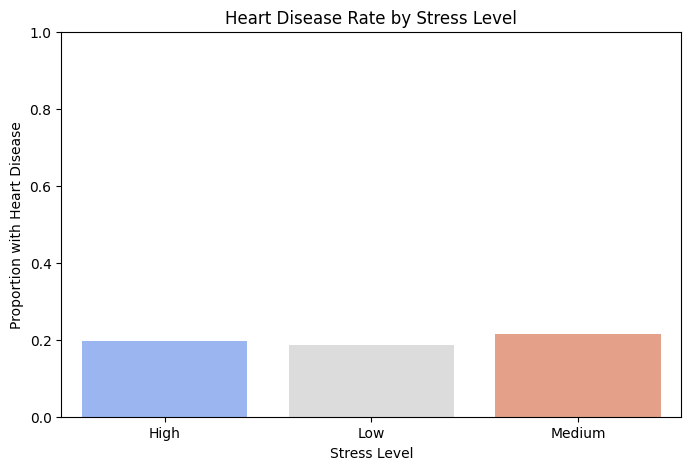

In [10]:
'''Stress Level vs. sleep hour vs. heart disease'''

if df['Heart Disease Status'].dtype == 'O':
    df['Heart Disease Status'] = df['Heart Disease Status'].map({'Yes': 1, 'No': 0})

# -------------------------------
# Chi-Square Test - Stress Level & Heart Disease
# -------------------------------
contingency_table = pd.crosstab(df["Stress Level"], df["Heart Disease Status"])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\nChi-Squared Test: Stress Level vs. Heart Disease Status")
print(f"Chi2: {chi2:.2f}, p-value: {p:.4f}")
if p < 0.05:
    print("=> There is a significant relationship between Stress Level and Heart Disease.")
else:
    print("=> No significant relationship between Stress Level and Heart Disease.")

# -------------------------------
# T-test / ANOVA - Sleep Hours Across Heart Disease Status
# -------------------------------
group_no_hd = df[df["Heart Disease Status"] == 0]["Sleep Hours"]
group_yes_hd = df[df["Heart Disease Status"] == 1]["Sleep Hours"]

t_stat, p_val = ttest_ind(group_no_hd, group_yes_hd, equal_var=False)
print("\nT-Test: Sleep Hours vs. Heart Disease Status")
print(f"T-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")
if p_val < 0.05:
    print("=> Sleep Hours significantly differs between those with and without Heart Disease.")
else:
    print("=> No significant difference in Sleep Hours between groups.")

# -------------------------------
# ANOVA - Sleep Hours Across Stress Levels
# -------------------------------
anova_p = f_oneway(
    df[df["Stress Level"] == "Low"]["Sleep Hours"],
    df[df["Stress Level"] == "Medium"]["Sleep Hours"],
    df[df["Stress Level"] == "High"]["Sleep Hours"]
)

print("\nANOVA: Sleep Hours vs. Stress Level")
print(f"F-statistic: {anova_p.statistic:.2f}, p-value: {anova_p.pvalue:.4f}")
if anova_p.pvalue < 0.05:
    print("=> Significant difference in Sleep Hours among different Stress Levels.")
else:
    print("=> No significant difference in Sleep Hours among Stress Levels.")

# Compute the proportion of people with heart disease in each stress level category
stress_hd = df.groupby("Stress Level")["Heart Disease Status"].mean().reset_index()

# Plot a bar chart
plt.figure(figsize=(8, 5))
sns.barplot(data=stress_hd, x="Stress Level", y="Heart Disease Status", palette="coolwarm")

plt.ylabel("Proportion with Heart Disease")
plt.title("Heart Disease Rate by Stress Level")
plt.ylim(0, 1)  # Since it's a proportion (0 to 1)
plt.show()


In [11]:
'''what factor affect gender vs heart disease'''
# Filter for patients with heart disease
df_hd = df[df["Heart Disease Status"] == 'Yes']

# Separate the heart disease patients by Gender
df_hd_f = df_hd[df_hd["Gender"] == "Female"]
df_hd_m = df_hd[df_hd["Gender"] == "Male"]



print("Continuous Variables Comparison between Female and Male Heart Disease Patients:")
results_continuous = []
for var in numerical_vars:
    
    # Perform an independent t-test
    t_stat, p_val = ttest_ind(df_hd_f[var], df_hd_m[var], equal_var=False)
    
    results_continuous.append({
        "Variable": var, 
        "t-statistic": t_stat, "p-value": p_val
    })

results_cont_df = pd.DataFrame(results_continuous)
print(results_cont_df)
for index, row in results_cont_df.iterrows():
    if row["p-value"] < 0.05:
        print(f"{row['Variable']} is a significant factor affecting heart disease rate among gender (p-value = {row['p-value']:.4f}).")

# -----------------------------------
# Categorical Variables Comparison
# -----------------------------------

if 'Gender' in categorical_vars:
    categorical_vars_gen = [x for x in categorical_vars if x != 'Gender']
print("\nCategorical Variables Comparison between Female and Male Heart Disease Patients:")
results_categorical = []
for var in categorical_vars_gen:
    # Build a contingency table for the variable and Gender
    contingency_table = pd.crosstab(df_hd[var], df_hd["Gender"])
    chi2, p_val, dof, expected = chi2_contingency(contingency_table)
    
    results_categorical.append({
        "Variable": var,
        "Chi2": chi2, "p-value": p_val
    })

results_cat_df = pd.DataFrame(results_categorical)
for index, row in results_cat_df.iterrows():
    if row["p-value"] < 0.05:
        print(f"{row['Variable']} is a significant factor affecting heart disease rate among gender (p-value = {row['p-value']:.4f}).")
# print(results_cat_df)

# Transform p-values to -log10(p_value) for easier visualization of significance.
results_cat_df["neg_log10_p"] = -np.log10(results_cat_df["p-value"])
results_cat_df = results_cat_df.sort_values("neg_log10_p", ascending=False)

# Create a color list to highlight Alcohol Consumption in red
colors = ['red' if var == "Alcohol Consumption" else 'grey' for var in results_cat_df["Variable"]]

plt.figure(figsize=(10, 6))
sns.barplot(x="neg_log10_p", y="Variable", data=results_cat_df, palette=colors)
plt.xlabel("-log10(p-value)")
plt.title("Significance of Categorical Factors on Heart Disease Status")

# Plot a vertical line representing the significance threshold (p = 0.05)
sig_threshold = -np.log10(0.05)
plt.axvline(x=sig_threshold, linestyle="--", color="blue", label="p = 0.05 threshold")
plt.legend()
plt.show()

Continuous Variables Comparison between Female and Male Heart Disease Patients:
              Variable  t-statistic  p-value
0                  Age          NaN      NaN
1       Blood Pressure          NaN      NaN
2    Cholesterol Level          NaN      NaN
3                  BMI          NaN      NaN
4          Sleep Hours          NaN      NaN
5   Triglyceride Level          NaN      NaN
6  Fasting Blood Sugar          NaN      NaN
7            CRP Level          NaN      NaN
8   Homocysteine Level          NaN      NaN

Categorical Variables Comparison between Female and Male Heart Disease Patients:


c:\Users\Francisco\tech_projects\ECE143_Project\heart-disease-analysis\venv\Lib\site-packages\scipy\_lib\deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


ValueError: No data; `observed` has size 0.

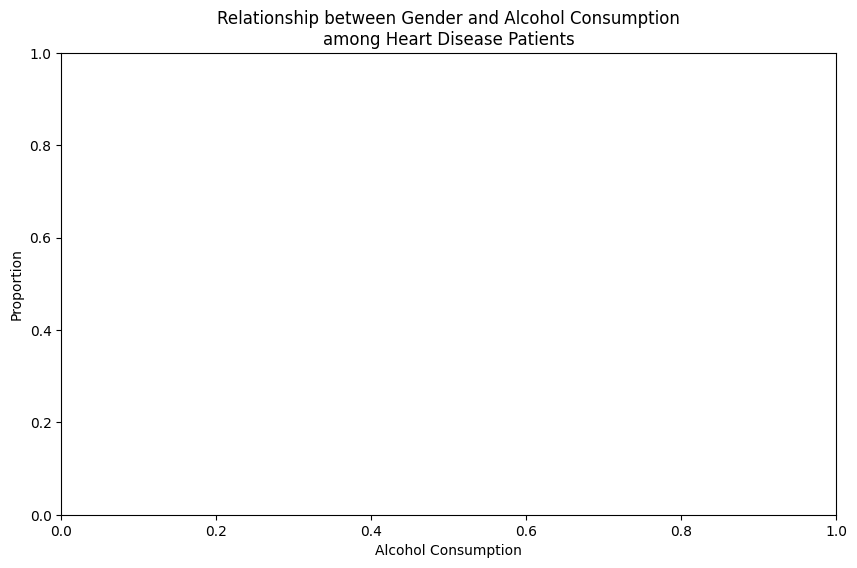

In [12]:
# Create a contingency table: rows = Alcohol Consumption, columns = Gender
ct = pd.crosstab(df_hd["Alcohol Consumption"], df_hd["Gender"])

# Normalize by columns so that for each gender, the sum of proportions equals 1
ct_norm = ct.div(ct.sum(axis=0), axis=1)

# Convert the table into a long format for plotting
ct_norm = ct_norm.reset_index().melt(id_vars="Alcohol Consumption", var_name="Gender", value_name="Proportion")

# Plot a grouped bar chart of normalized proportions
plt.figure(figsize=(10, 6))
sns.barplot(data=ct_norm, x="Alcohol Consumption", y="Proportion", hue="Gender", palette="viridis")
plt.title("Relationship between Gender and Alcohol Consumption\namong Heart Disease Patients")
plt.xlabel("Alcohol Consumption")
plt.ylabel("Proportion")
plt.ylim(0, 1)
plt.show()

C:\Users\Francisco\AppData\Local\Temp\ipykernel_17608\1054459809.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="neg_log10_p", y="Variable", data=results_df, palette=colors)


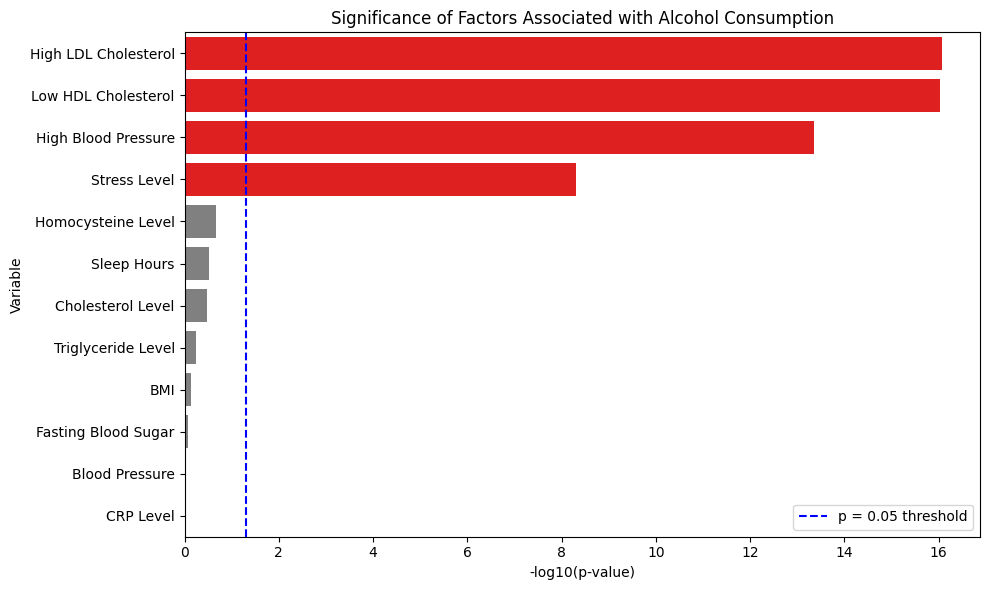

In [13]:
'''alcohol consumption can affect what'''

numerical_vars = [
    "Blood Pressure", "Cholesterol Level", "BMI", "Sleep Hours", 
    "Triglyceride Level", "Fasting Blood Sugar", "CRP Level", "Homocysteine Level"
]

categorical_vars_al = ['High Blood Pressure', 'Low HDL Cholesterol', 'High LDL Cholesterol', 'Stress Level']
results_cont = []
# Evaluate continuous variables using one-way ANOVA across different alcohol consumption groups
for var in numerical_vars:
    # Get the groups by alcohol consumption level
    groups = [group[var] for name, group in df.groupby('Alcohol Consumption')]
    if len(groups) > 1:  # Only if there are at least 2 groups
        f_stat, p_val = f_oneway(*groups)
        results_cont.append({
            "Variable": var,
            "Test": "ANOVA",
            "Statistic": f_stat,
            "p-value": p_val
        })

results_cat = []
# Evaluate categorical variables using a chi-square test
for var in categorical_vars_al:
    contingency = pd.crosstab(df[var], df['Alcohol Consumption'])
    chi2, p_val, dof, expected = chi2_contingency(contingency)
    results_cat.append({
        "Variable": var,
        "Test": "Chi-square",
        "Statistic": chi2,
        "p-value": p_val
    })

# Combine the results into one DataFrame
results_df = pd.DataFrame(results_cont + results_cat)

# Calculate -log10(p-value) for easier visualization (larger values = more significant)
results_df["neg_log10_p"] = -np.log10(results_df["p-value"])

# Flag significant factors (p < 0.05)
results_df["Significant"] = results_df["p-value"] < 0.05

# Sort results for plotting
results_df = results_df.sort_values("neg_log10_p", ascending=False)

# Plot the results
plt.figure(figsize=(10, 6))
# Color bars red if significant, grey otherwise
colors = ["red" if sig else "grey" for sig in results_df["Significant"]]
sns.barplot(x="neg_log10_p", y="Variable", data=results_df, palette=colors)
plt.xlabel("-log10(p-value)")
plt.title("Significance of Factors Associated with Alcohol Consumption")

# Draw the significance threshold line (p=0.05 corresponds to -log10(0.05))
sig_threshold = -np.log10(0.05)
plt.axvline(x=sig_threshold, linestyle="--", color="blue", label="p = 0.05 threshold")
plt.legend()
plt.tight_layout()
plt.show()

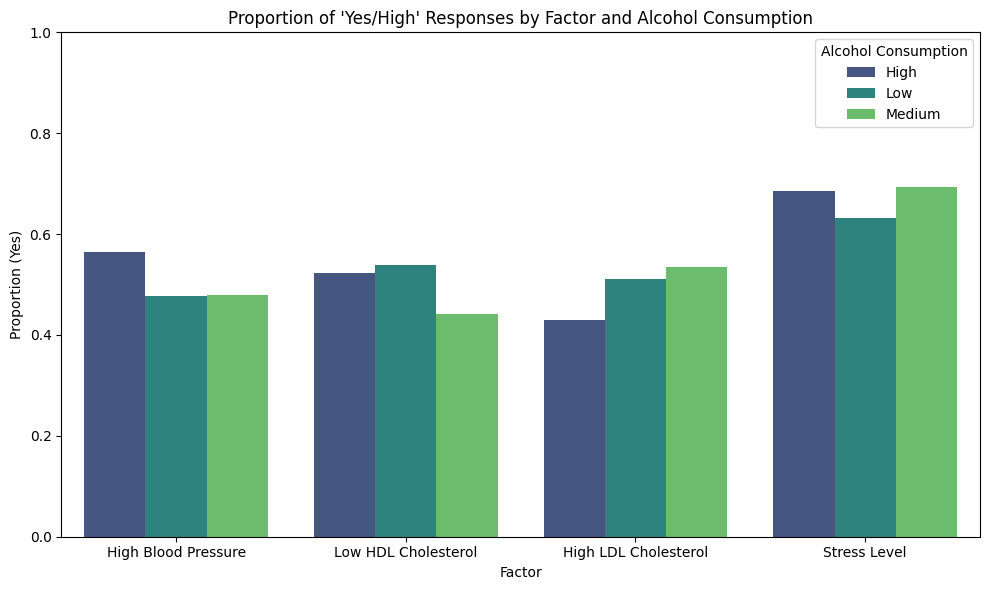

In [14]:
# List of factors to examine
factors = ['High Blood Pressure', 'Low HDL Cholesterol', 'High LDL Cholesterol', 'Stress Level']

# Hold aggregated normalized data
agg_data = []

# Get the sorted unique categories for Alcohol Consumption
alc_categories = sorted(df["Alcohol Consumption"].unique())

for factor in factors:
    for alc in alc_categories:
        subset = df[df["Alcohol Consumption"] == alc]
        # Use "High" for Stress Level, "Yes" for others
        # pos_val = "High" or pos_val == "Medium" if factor == "Stress Level" else "Yes"
        # proportion = (subset[factor] == pos_val).mean()
        if factor == "Stress Level":
            # Compute proportion for stress level being either "High" or "Medium"
            proportion = ((subset[factor] == "High") | (subset[factor] == "Medium")).mean()
        else:
            # For binary factors where "Yes" indicates positive
            proportion = (subset[factor] == "Yes").mean()
        agg_data.append({
            "Factor": factor,
            "Alcohol Consumption": alc,
            "Proportion": proportion
        })

# Create a DataFrame from the aggregated data
agg_df = pd.DataFrame(agg_data)

# Plot a grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=agg_df, x="Factor", y="Proportion", hue="Alcohol Consumption", palette="viridis")
plt.title("Proportion of 'Yes/High' Responses by Factor and Alcohol Consumption")
plt.xlabel("Factor")
plt.ylabel("Proportion (Yes)")
plt.ylim(0, 1)
plt.legend(title="Alcohol Consumption", loc="upper right")
plt.tight_layout()
plt.show()